In [94]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import json
import matplotlib.pyplot as plt


def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

class ARC_Dataset(Dataset):
    def __init__(self, challenges, solution):
        challenges = load_json(challenges)
        solution = load_json(solution)
        self.data = []

        for key, value in challenges.items():
            for i in range(len(value['test'])):
                task_input = value['test'][i]['input']
                task_output = solution[key][i]

                example_input_list = [ex['input'] for ex in value['train']]
                example_output_list = [ex['output'] for ex in value['train']]
                num_examples = len(example_input_list)

                # 모든 가능한 예제 조합 생성 (예제 3쌍씩)
                for idx in range(0, num_examples, 3):
                    ex_inputs = example_input_list[idx:idx+3]
                    ex_outputs = example_output_list[idx:idx+3]

                    # 예제가 3개보다 적으면 복제하여 3개로 만듦
                    while len(ex_inputs) < 3:
                        ex_inputs.append(example_input_list[idx % num_examples])
                        ex_outputs.append(example_output_list[idx % num_examples])
                        idx += 1

                    self.data.append({
                        'id': key,
                        'task_input': task_input,
                        'task_output': task_output,
                        'example_inputs': ex_inputs,
                        'example_outputs': ex_outputs
                    })

        # 리스트를 데이터프레임으로 변환
        self.df = pd.DataFrame(self.data)

    def __len__(self):
        return len(self.df)
    
    def pad_to_30x30(self, tensor):
        if tensor.dim() == 2:
            tensor = tensor.unsqueeze(0)
        c, h, w = tensor.shape
        pad_h = max(0, 30 - h)
        pad_w = max(0, 30 - w)
        padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
        tensor = F.pad(tensor, padding, mode='constant', value=0)
        return tensor

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 작업 입력과 출력 변환 및 패딩
        task_input = self.pad_to_30x30(torch.tensor(row['task_input'], dtype=torch.float32) + 1)
        task_output = self.pad_to_30x30(torch.tensor(row['task_output'], dtype=torch.float32) + 1)

        # 예제 입력과 출력 변환 및 패딩
        example_inputs = []
        example_outputs = []
        for ex_inp, ex_out in zip(row['example_inputs'], row['example_outputs']):
            ex_inp_padded = self.pad_to_30x30(torch.tensor(ex_inp, dtype=torch.float32) + 1)
            ex_out_padded = self.pad_to_30x30(torch.tensor(ex_out, dtype=torch.float32) + 1)
            example_inputs.append(ex_inp_padded)
            example_outputs.append(ex_out_padded)

        # 예제 입력과 출력을 텐서로 스택
        example_input = torch.stack(example_inputs)
        example_output = torch.stack(example_outputs)

        return task_input, task_output, example_input, example_output

# 데이터셋 인스턴스 생성
train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"

train_dataset = ARC_Dataset(train_challenge, train_solution)


In [90]:
def one_hot_encoding(tensor):
    tensor = F.one_hot(tensor.long(), num_classes=11)
    tensor = tensor.permute(0, 3, 1, 2)
    tensor = tensor.squeeze(0)        
    return tensor

In [92]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

ti, to, ei, eo = next(iter(train_loader))

print(ti.shape, to.shape, ei.shape, eo.shape)

torch.Size([10, 1, 30, 30]) torch.Size([10, 1, 30, 30]) torch.Size([10, 3, 1, 30, 30]) torch.Size([10, 3, 1, 30, 30])


In [87]:
ex = ei[0,0]
print(ex.shape)
ex = one_hot_encoding(ex)
print(ex.shape)

torch.Size([1, 30, 30])
torch.Size([11, 30, 30])


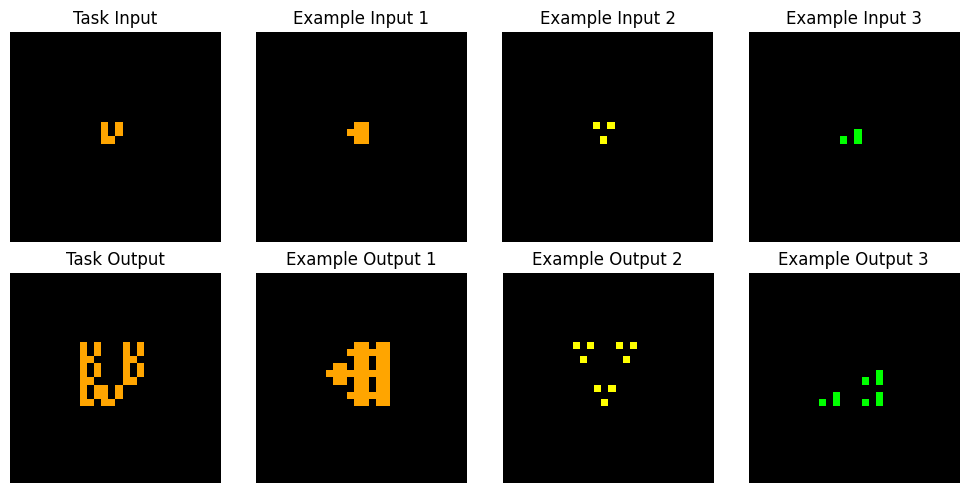

In [95]:
# 데이터셋에서 첫 번째 샘플을 가져옵니다.
task_input, task_output, example_input, example_output = train_dataset[0]

# 텐서를 NumPy 배열로 변환하고, 클래스 인덱스를 원래대로 복원하기 위해 1을 빼줍니다.
task_input_np = task_input.squeeze().numpy() - 1
task_output_np = task_output.squeeze().numpy() - 1
example_input_np = example_input.squeeze().numpy() - 1
example_output_np = example_output.squeeze().numpy() - 1

# 시각화를 위해 컬러맵을 정의합니다.
from matplotlib.colors import ListedColormap

# ARC 데이터셋의 컬러맵 (10가지 색상)
arc_colors = [
    (0, 0, 0),         # 0: 검정
    (255, 0, 0),       # 1: 빨강
    (0, 255, 0),       # 2: 초록
    (0, 0, 255),       # 3: 파랑
    (255, 255, 0),     # 4: 노랑
    (255, 0, 255),     # 5: 마젠타
    (0, 255, 255),     # 6: 시안
    (255, 165, 0),     # 7: 주황
    (128, 0, 128),     # 8: 보라
    (128, 128, 128),   # 9: 회색
]

# RGB 값을 [0,1] 범위로 변환
arc_colors = [(r/255, g/255, b/255) for r, g, b in arc_colors]
cmap = ListedColormap(arc_colors)

# 시각화 함수 정의
def plot_grid(grid, title):
    plt.imshow(grid, cmap=cmap, interpolation='nearest', vmin=0, vmax=9)
    plt.title(title)
    plt.axis('off')

# 플롯 크기 설정
plt.figure(figsize=(10, 5))

# 작업 입력과 출력 시각화
plt.subplot(2, 4, 1)
plot_grid(task_input_np, 'Task Input')

plt.subplot(2, 4, 5)
plot_grid(task_output_np, 'Task Output')

# 예제 입력/출력 시각화
for i in range(3):
    plt.subplot(2, 4, i+2)
    plot_grid(example_input_np[i], f'Example Input {i+1}')

    plt.subplot(2, 4, i+6)
    plot_grid(example_output_np[i], f'Example Output {i+1}')

plt.tight_layout()
plt.show()